In [1]:
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("./data/KRX_000660_2020_.csv", index_col="Date", parse_dates=["Date"])
df.head(10)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,96000,96200,94100,94700,2342070,0.006376
2020-01-03,96500,97900,94300,94500,3021380,-0.002112
2020-01-06,93000,95300,92800,94300,2577573,-0.002116
2020-01-07,94500,95400,94000,94000,2489429,-0.003181
2020-01-08,96400,99500,95200,97400,7014748,0.036170
2020-01-09,98900,99000,97400,99000,3586413,0.016427
2020-01-10,99100,99700,97900,98900,2867925,-0.001010
2020-01-13,99000,101000,98000,100500,2242008,0.016178
2020-01-14,101500,103500,99900,100500,2913343,0.000000


In [4]:
# 결측치 확인
df[df.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

,Open,High,Low,Close,Volume,Change
Date,,,,,,


In [31]:
df.isin([np.nan, np.inf, -np.inf])

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,False,False,False,False,False,False
2020-01-03,False,False,False,False,False,False
2020-01-06,False,False,False,False,False,False
2020-01-07,False,False,False,False,False,False
2020-01-08,False,False,False,False,False,False
...,...,...,...,...,...,...
2023-01-04,False,False,False,False,False,False
2023-01-05,False,False,False,False,False,False
2023-01-06,False,False,False,False,False,False


In [5]:
# any() 함수
df.isin([np.nan, np.inf, -np.inf]).any(axis=0)

Open      False
High      False
Low       False
Close     False
Volume    False
Change    False
dtype: bool

In [6]:
df.isin([np.nan, np.inf, -np.inf]).any(axis=1)

Date
2020-01-02    False
2020-01-03    False
2020-01-06    False
2020-01-07    False
2020-01-08    False
              ...  
2023-01-04    False
2023-01-05    False
2023-01-06    False
2023-01-09    False
2023-01-10    False
Length: 749, dtype: bool

<AxesSubplot: xlabel='Date'>

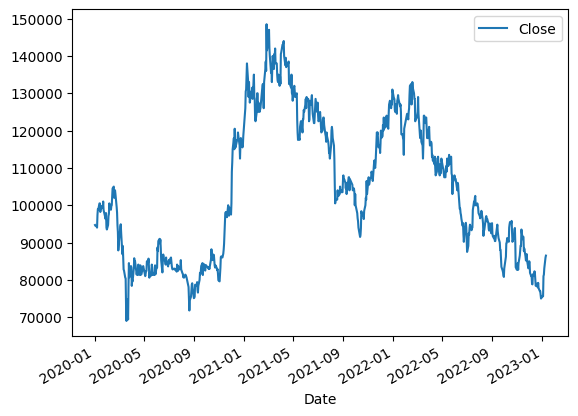

In [7]:
#df_price = df.Close.copy() # series 생성
df_price = df.loc[:,["Close"]].copy() # dataframe 생성
df_price.plot()

<AxesSubplot: xlabel='Date'>

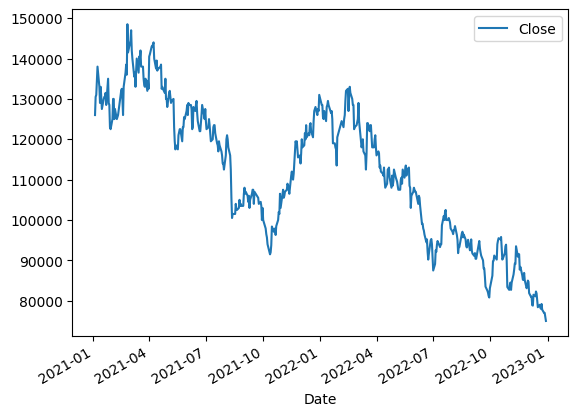

In [8]:
# 인덱스 from : to
df_price.loc["2021":"2022"].plot()

In [9]:
# 일별 수익률
df_price["daily_rtn"] = df.Close.pct_change()
df_price.head(10)

,Close,daily_rtn
Date,,
2020-01-02,94700,NaN
2020-01-03,94500,-0.002112
2020-01-06,94300,-0.002116
2020-01-07,94000,-0.003181
2020-01-08,97400,0.036170
2020-01-09,99000,0.016427
2020-01-10,98900,-0.001010
2020-01-13,100500,0.016178
2020-01-14,100500,0.000000


In [10]:
# 누적 수익률 구하기
df_price['st_rtn'] = (df_price.daily_rtn+1).cumprod() # +1 => -값을 양수로 전환 ex) -0.1 => 0.9
df_price.tail(10)

,Close,daily_rtn,st_rtn
Date,,,
2022-12-27,77000,0.000000,0.813094
2022-12-28,76000,-0.012987,0.802534
2022-12-29,75000,-0.013158,0.791975
2023-01-02,75700,0.009333,0.799366
2023-01-03,75600,-0.001321,0.798310
2023-01-04,81000,0.071429,0.855333
2023-01-05,81400,0.004938,0.859556
2023-01-06,83100,0.020885,0.877508
2023-01-09,86000,0.034898,0.908131


누적수익: 0.9086134453781508


<AxesSubplot: xlabel='Date'>

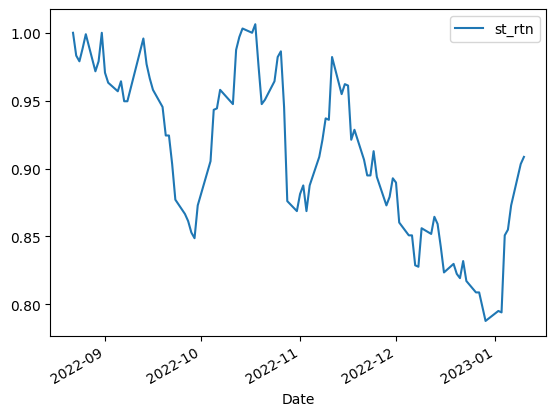

In [11]:
# 별도의 시점에서 누적 수익률 구하기
base_date = "2022-08-22"
df_tmp = df_price.loc[base_date:, ['st_rtn']] / df_price.loc[base_date,'st_rtn']
print(f"누적수익: {df_tmp.iloc[-1].st_rtn}")
df_tmp.plot()

In [22]:
# 연평균 복리 수익률
last_index = df_price.index[-1]
CAGR = df_price.loc[last_index, 'st_rtn']**(252./len(df_price.index))-1
print(f"CAGR: {CAGR:.2f}")

CAGR: -0.03


MDD: 0.4949


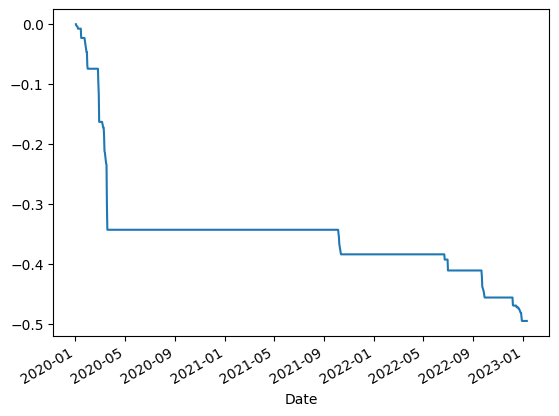

In [30]:
# 최대 낙폭(MDD)
historical_max = df_price.Close.cummax() # 누적 최댓값 반환
#print(historical_max)
daily_drawdown = df_price.Close / historical_max -1 # 일별 낙폭값
historical_dd = daily_drawdown.cummin() # 누적 최소값 반환
historical_dd.plot()
print(f"MDD: {historical_dd[-1]*-1:.4f}")


In [26]:
# 변동성 = 일별 수익률 표준편차 * √영업일
VOL = np.std(df_price.daily_rtn)*np.sqrt(252.)
print(f"변동성: {VOL:.2f}")

변동성: 0.37


In [28]:
# 사후적 샤프(위험 대비 수익성 지표) 비율
# 실현 수익률의 평균 / 실현 수익률의 변동성(VOL)

Sharp = df_price.daily_rtn.mean() / VOL
print(f"사프: {Sharp:.4f}")

사프: 0.0004
